# Домашняя работа.
### Продвинутые архитектуры свёрточных нейросетей

In [10]:
from tensorflow.python.client import device_lib
str(device_lib.list_local_devices()[-1]).split('\n')[-2]

'physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"'

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
tf.__version__

'2.2.0'

In [0]:
IMG_CHANNELS = 3 
MAX_SIZE = 224
CLASSES = 101

EPOCHS = 2
BATCH_SIZE = 32
VERBOSE = 1
OPTIMIZER = tf.keras.optimizers.RMSprop(lr=0.0001)
VALIDATION_SPLIT = 0.1


In [0]:
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

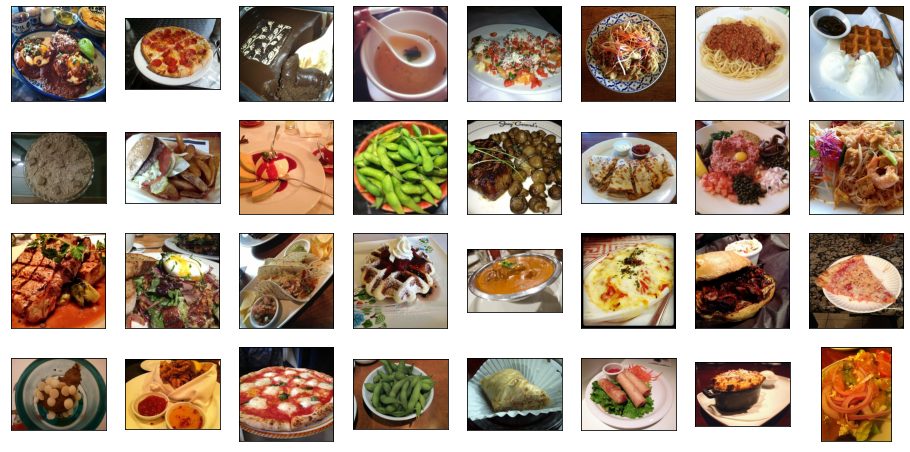

In [14]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()


In [0]:
def prepare(img, label):
    img = tf.cast(img, tf.float32)/255.
    return tf.image.resize(img, (MAX_SIZE, MAX_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

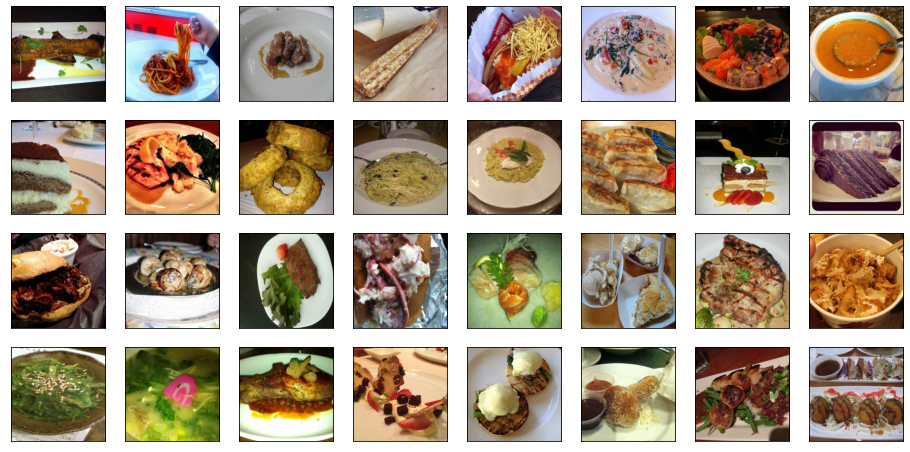

In [16]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j].numpy()[0,:, :,:])
    plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
def create_model(num_classes, dropout, shape):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=tf.keras.layers.Input(
            shape=shape))

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Flatten()(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model_final = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

    return model_final

model = create_model(CLASSES, 0.25, (MAX_SIZE, MAX_SIZE, IMG_CHANNELS))

In [0]:
model.compile(optimizer=OPTIMIZER,
              loss = "sparse_categorical_crossentropy",
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/transfer', 
    write_graph=False, update_freq=100, profile_batch=0)

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [20]:
%%time

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/2
2130/2130 [==============================] - 1631s 766ms/step - loss: 1.9504 - accuracy: 0.5194 - val_loss: 1.5356 - val_accuracy: 0.6167
Epoch 2/2
2130/2130 [==============================] - 1625s 763ms/step - loss: 1.0363 - accuracy: 0.7252 - val_loss: 1.4948 - val_accuracy: 0.6504
CPU times: user 46min 34s, sys: 15min 31s, total: 1h 2min 5s
Wall time: 54min 44s


In [21]:
%%time

model.evaluate(test_ds)

236/236 [==============================] - 51s 215ms/step - loss: 1.4970 - accuracy: 0.6507
CPU times: user 1min 4s, sys: 12.2 s, total: 1min 16s
Wall time: 52.5 s


[1.4969534873962402, 0.6506885886192322]